<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/1010_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D%EC%8B%A4%EC%8A%B5_%EB%A9%94%EB%A3%A8%EC%B9%B4%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 분석 실습 캐글 메루카리

일본의 대형 온라인 쇼핑몰 메루카리사의 제품 가격 예측
- 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 데이터 세트가 구성됨.
- 회귀로 피처를 학습한 뒤 price를 예측하는 문제
- 기존 회귀와 달리 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행

In [15]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [16]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name 칼럼의 경우 가격에 영향을 미치는 중요 요인으로 판단되나, 많은 데이터가 Null로 돼 있음.

category_name과 item_description도 미미한 결측치 존재.

## 타깃값 칼럼 price의 데이터 분포도 확인

왜곡된 분해이므로 로그 변환 필요해 보임

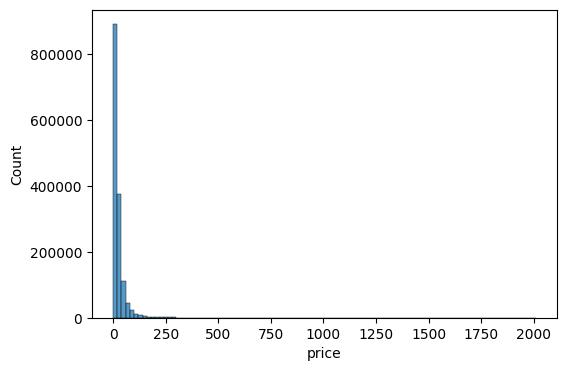

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

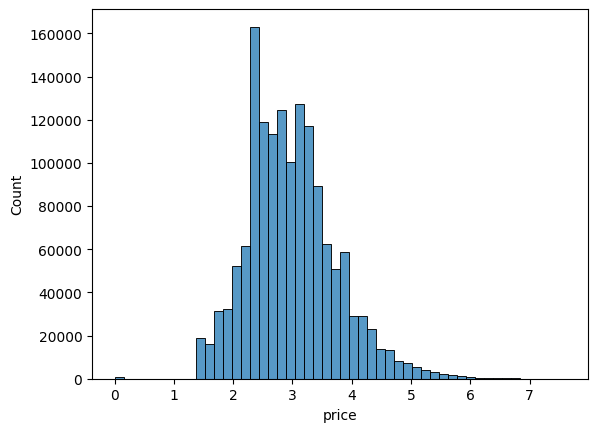

In [18]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [19]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [20]:
# 배송비 유무 칼럼
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())

# 판매자가 제공하는 제품 상태
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [21]:
# description에 대한 별도 설명이 없는 행의 개수

boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

'No description yet'으로 채워진 값은 null과 마찬가지로 의미 있는 속성값으로 사용될 수 없으므로 적절하게 변경해야 함.

## category_name

'/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음.

- 'Men/Tops/T-shirts'는 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'로 나눌 수 있음
- 텍스트 데이터이기 때문에 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수 있음
- category_name의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하는 방법도 가능
> 별도의 split_cat() 함수를 생성하고 이를 DataFrame의 apply lambda 식에 적용하여 대, 중, 소분류를 효과적으로 분리해 낼 것

  > null이 아닌 경우 split('/')를 이용해 대, 중, 소를 분류
  
  > null일 경우에는 split() 함수가 error를 발생하므로 except catch하여 대, 중, 소 분류 모두 other null 값을 부여함

In [23]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(text):
    try:
        return text.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 유형:\n', mercari_df['cat_jung'].nunique())
print('소분류 유형:\n', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형:
 114
소분류 유형:
 871


null값이 많았던 칼럼은 다른 값으로 변경하기보다는 category_name처럼 똑같이 일괄적으로 other null 처리.

In [24]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


# 피처 인코딩과 피처 벡터화

문자열 칼럼 중 레이블 또는 원핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별

- 선형 회귀의 경우 원핫 인코딩 적용이 훨씬 선호됨 -> 인코딩할 피처를 모두 원핫 인코딩 적용
- 피처 벡터화의 경우는 비교적 짧은 텍스트일 때 Count 기반 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화 적용

## 1. brand_name

상품의 브랜드명이 담긴 칼럼

In [25]:
print('brand name의 유형 건수: ', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수:  4810
brand name sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


대부분 명료한 문자열이므로 별도의 피처 벡터화 없이 인코딩 변환 적용

종류가 4810건이나 ML 모델 구축상 큰 문제는 없으니 진행

## 2. name

상품명을 의미하는 name 속성

In [26]:
print('name의 종류 개수: ', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 개수:  1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


거의 개별적으로 고유한 상품명을 가지고 있기 때문에 종류가 매우 많음. 다만 적은 단어 위주의 텍스트 형태이므로, count 기반 벡터화 변환 적용

## 3. category_name

이전 전처리를 통해서 해당 칼럼은 대, 중, 소 분류 세 개의 칼럼으로 분리됨. 해당 칼럼들도 원핫 인코딩 적용

## 4. shipping

배송비 무료 여부로, 원핫 인코딩

## 5. item_condition_id

상품 상태로서 1, 2, 3, 4, 5의 다섯 가지 유형 값을 가짐. 원핫 인코딩 적용

## 6. item_description

상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트를 가짐. 해당 칼럼의 평균 문자열 크기와 2개 정도의 텍스트만 출력 -> 확인 결과 평균 문자열이 145자이므로 TF-IDF 변환 진행

In [27]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기: ', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기:  145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


In [28]:
# name 속성에 대한 피처 벡터화 변환

cnt_vect = CountVectorizer()
X_name = cnt_vect.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])
print('name vectorization shape: ', X_name.shape)
print('item_description vectorization shape: ', X_descp.shape)

name vectorization shape:  (1482535, 105757)
item_description vectorization shape:  (1482535, 50000)


CountVectorizer, TfidVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태. 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩될 칼럼들도 모두 이 두 객체 변수와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 함.

이를 위해 인코딩 대상 칼럼도 밀집 행렬이 아닌 희소 행렬 형태로 인코딩 적용한 뒤 함께 결합.

## OneHotEncoder와 LabelBinarizer

LabelBinarizer 클래스는 희소 행렬 형태의 원핫 인코딩 변환을 지원.생성 시 sparse_out = True로 파라미터를 설정해 주기만 하면 됨.

이후 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합. 이 함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해 줌.

In [29]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [30]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape: {0}, X_cat_dae shape: {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape: {0}, X_cat_so shape: {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape: (1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제 되지 않음.

이번에는 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합.

In [31]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


538

# 릿지 회귀 모델 구축 및 평가

낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 RMSLE 사용

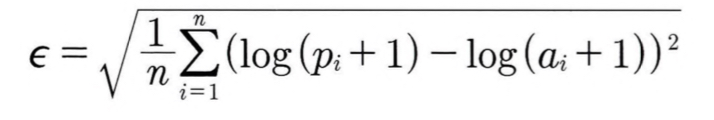

In [32]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [37]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

릿지를 이용해 회귀 예측을 수행. 이전에 텍스트 형태의 속성이 얼마나 영향을 미치는지 살펴보기 -> 피처 벡터화 데이터가 포함될 때와 아닐 때 예측 성능이 얼마나 차이 나는지

In [38]:
from sklearn.linear_model import Ridge

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값:  0.4983990938999374
Item Description을 포함했을 때 rmsle 값:  0.4680432471796771


In [ ]:
# from lightgbm import LGBMRegressor

# sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
# lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
# print('LightGBM rmsle 값: ', evaluate_org_price(y_test, lgbm_preds))

In [ ]:
# preds = lgbm_preds * 0.45 + linear_preds * 0.55
# print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))